# Part 1: OpenMC Basics

Welcome to the OpenMC workshop. This part will show the very basics of input file syntax using OpenMC's Python API

<span style="color:red">HINTS:</span>
* To run the commands, click on the relevant cell and hit the `shift + enter` keys simultaneously
* You need to fill in some code indicated wih `#TODO`s

Debugging tips
* Did you run all of the cells above your current cell? Try `Run -> Run All Above Selected Cell` from the menu
* Has the cell accidentally been switched from a `Code` cell to a `Raw` or `Markdown` cell? Check the dropdown menu that is to the far right of the save button
* If all else fails, switch over to the filled-in .ipynb file.

# Materials

We will start by defining the materials that we need for a pincell problem. Here are UO2 and zirconium materials, for example.

In [1]:
import openmc

In [2]:
uo2 = openmc.Material()
uo2.add_element('U', 1.0, enrichment=3.2)
uo2.add_element('O', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material()
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

Now, you try adding the elements we need for H2O water.

In [3]:
water = openmc.Material()

Try using Jupyter's auto-completion tools, type just `water.` then hit `tab` which should give you a dropdown menu. (You will need to evaluate the cell above first so that `water` is defined.)

<span style="color:red">Extra input is needed here</span>

In [4]:
#TODO: add 2 H and 1 O to the water material.
water.add_element('H', 2.0)
water.add_element('O', 1.0)
water.set_density('g/cm3', 0.7)

For some materials like water, you will also need to add S($\alpha$, $\beta$) tables which describe thermal neutron cross sections for the combined molecule

In [5]:
water.add_s_alpha_beta('c_H_in_H2O')

Now we have defined our materials in Python, but we need to write them out to an XML file that the C++ physics solver can read. The `cat` command below will show you what the actual XML files look like.

In [6]:
materials = openmc.Materials([uo2, zirconium, water])
materials.export_to_xml()

In [7]:
!cat materials.xml

<?xml version='1.0' encoding='utf-8'?>
<materials>
  <material depletable="true" id="1">
    <density units="g/cm3" value="10.0" />
    <nuclide ao="0.0002895591829726249" name="U234" />
    <nuclide ao="0.03239590764444486" name="U235" />
    <nuclide ao="0.9671661443552968" name="U238" />
    <nuclide ao="0.00014838881728587684" name="U236" />
    <nuclide ao="1.999242" name="O16" />
    <nuclide ao="0.000758" name="O17" />
  </material>
  <material id="2">
    <density units="g/cm3" value="6.6" />
    <nuclide ao="0.5145" name="Zr90" />
    <nuclide ao="0.1122" name="Zr91" />
    <nuclide ao="0.1715" name="Zr92" />
    <nuclide ao="0.1738" name="Zr94" />
    <nuclide ao="0.028" name="Zr96" />
  </material>
  <material id="3">
    <density units="g/cm3" value="0.7" />
    <nuclide ao="1.99968852" name="H1" />
    <nuclide ao="0.00031148" name="H2" />
    <nuclide ao="0.999621" name="O16" />
    <nuclide ao="0.000379" name="O17" />
    <sab name="c_H_in_H2O" />
  </material>
</materia

# Geometry

Next, let's define the geometry, starting with the surfaces. OpenMC supports many basic shapes like planes, cylinders, and cones. Here are the cylinders we'll need for the pincell problem.

In [8]:
fuel_or = openmc.ZCylinder(r=0.39)
clad_ir = openmc.ZCylinder(r=0.40)
clad_or = openmc.ZCylinder(r=0.46)

Note that this is a Python script so we can easily define helper variables and do math directly in the input file.

Specify a YPlane named `top` that is located at `pitch / 2`.

<span style="color:red">Extra input is needed here</span>

In [9]:
pitch = 1.26

In [10]:
left = openmc.XPlane(x0=-pitch/2)
right = openmc.XPlane(x0=pitch/2)
bottom = openmc.YPlane(y0=-pitch/2)
top = openmc.YPlane(y0=pitch/2)
#TODO: specify a YPlane named "top" with a y0 of pitch / 2.

We also need to specify boundary conditions on the surfaces, where appropriate. We can use `reflective`, `vacuum`, or `periodic` BCs.

In [11]:
left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'
top.boundary_type = 'reflective'

Next come the cells. Here we must specify what material is inside of each cell and what region of the geometry it covers.

Regions are specified with Boolean logic. We use `+` and `-` to indicate which side of a surface we want (e.g. the `-` for the inside of a cylinder and `+` for the outside). We can the combine them with the operators `&, |, ~` (and, or, not). You can also use parentheses, `(, )`.

In [12]:
fuel = openmc.Cell()
fuel.fill = uo2
fuel.region = -fuel_or

In [13]:
gap = openmc.Cell()
gap.fill = None
gap.region = +fuel_or & -clad_ir

Try specifying a `clad` cell that contains `zirconium` and lies outside of the `clad_ir` surface and inside of the `clad_or` surface.

<span style="color:red">Extra input is needed here</span>

In [14]:
clad = openmc.Cell()
clad.fill = zirconium
clad.region = +clad_ir & -clad_or
#TODO: set the fill to zirconium
#TODO: set the region to +clad_ir & -clad_or

In [15]:
coolant = openmc.Cell()
coolant.fill = water
coolant.region = +clad_or & +left & -right & +bottom & -top

A collection of cells is called a universe. This is a useful concept because we can define multi-layered geometry by using a universe as a fill, e.g. `cell.fill = univ`. We can also put universes into rectangular or hexagonal lattices for repetitive structures like fuel assemblies.

In [16]:
univ = openmc.Universe()
univ.add_cells([fuel, gap, clad, coolant])

You can also plot the geometry directly from Python.

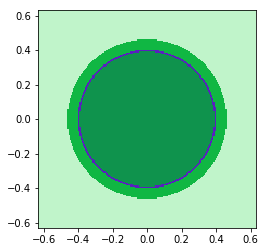

In [17]:
univ.plot(width=(pitch, pitch))

In [18]:
geom = openmc.Geometry(univ)
geom.export_to_xml()

# Starting source and settings

Now come the settings. First, we will specify the initial source. Here we will just use a point source at the origin, but there are many options available here. You can specify multiple sources with different strengths and you can specify distributions for the energy and direction for each source.

In [19]:
settings = openmc.Settings()

In [20]:
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)
settings.source = src

Next, we need to specify how many batches to run, how many inactive batches, and how many particles per batch.

Try setting the number of particles to 1000.

<span style="color:red">Extra input is needed here</span>

In [21]:
settings.batches = 100
settings.inactive = 10
settings.particles = 1000
#TODO: set the number of particles to 1000

settings.export_to_xml()

# Tallies

Now for the last step: specifying tallies. Tallies will tell us information about the fluxes, currents, and reaction rates in the problem. We can use filters to discretize the tallies by cells, materials, universes, energy, spherical harmonics moments, and many other attributes.

In [22]:
cell_filter = openmc.CellFilter([fuel, clad, coolant])

In [23]:
tally = openmc.Tally()
tally.filters = [cell_filter]
tally.scores = ['total', 'absorption']

In [24]:
tallies = openmc.Tallies([tally])

# Tallies for multigroup cross sections

A feature we want you to be aware of: OpenMC has automated pre- and post-processing features for generating MGXS (multigroup cross sections).

Don't worry much about the syntax here; just know to look for these features if you need them!

In [25]:
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = [0., 0.625, 20.0e6]

In [26]:
mgxs_lib = openmc.mgxs.Library(geom)
mgxs_lib.energy_groups = groups
mgxs_lib.mgxs_types = ['nu-fission', 'scatter matrix', 'chi']

In [27]:
mgxs_lib.domain_type = 'material'
mgxs_lib.domains = materials

In [28]:
mgxs_lib.build_library()
mgxs_lib.add_to_tallies_file(tallies)

In [29]:
tallies.export_to_xml()

/home/smharper/openmc/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=29.
  warn(msg, IDWarning)
/home/smharper/openmc/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)
/home/smharper/openmc/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=6.
  warn(msg, IDWarning)


# Running OpenMC

Okay, now we are finally ready to run the code! Here we will use the Python API's `run` function. We could instead call `openmc` (or maybe `mpiexec openmc`) from the terminal.

In [30]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

We can see the eigenvalue from the output above. The more interesting output data---the tally results---are stored in an HDF5 statepoint file. We'll talk about how to analyze that in the next section of the workshop.

But for simple datasets we can also use the `tallies.out` text file that is automatically written by the code. Here's what that looks like:

In [31]:
!cat tallies.out

 ============================>     TALLY 1     <============================

 Cell 1
   Total Material
     Total Reaction Rate                  6.15083 +/- 0.00998921
     Absorption Rate                      0.9412 +/- 0.00312478
 Cell 3
   Total Material
     Total Reaction Rate                  1.47180 +/- 0.00243029
     Absorption Rate                      0.00979174 +/- 8.31879e-05
 Cell 4
   Total Material
     Total Reaction Rate                  22.1229 +/- 0.0459207
     Absorption Rate                      0.0477804 +/- 0.000225718
 ===========================>     TALLY 24     <============================

 Material 1
   Incoming Energy [0.0, 0.625)
     Total Material
       Flux                                 1.86255 +/- 0.00774245
       Nu-Fission Rate                      1.10929 +/- 0.00529943
   Incoming Energy [0.625, 20000000.0)
     Total Material
       Flux                                 11.9268 +/- 0.0230175
       Nu-Fission Rate                      0.26